In [1]:
from transformers import pipeline


translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="eng_Latn", tgt_lang="mal_Mlym")
translator(["Hello, how are you?", "This is a test sentence."])

/Users/amaljoe/Desktop/Workspace/IITB/CS772/doctr/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


[{'translation_text': 'ഹലോ, എങ്ങിനെ പോകുന്നു?'},
 {'translation_text': 'ഇത് ഒരു പരീക്ഷണ വാക്യമാണ്.'}]

In [5]:
import cv2
from doclayout_yolo import YOLOv10

# Load the pre-trained model
model = YOLOv10("../models/yolo.pt")

# Perform prediction
det_res = model.predict(
    "../data/mydata/flight.png",   # Image to predict
    imgsz=1024,        # Prediction image size
    conf=0.2,          # Confidence threshold
    device="mps"
)

# Annotate and save the result
annotated_frame = det_res[0].plot(pil=True, line_width=5, font_size=20)
# cv2.imwrite("../outputs/mydata/flight.jpg", annotated_frame)


image 1/1 /Users/amaljoe/Desktop/Workspace/IITB/CS772/doctr/notebooks/../data/mydata/flight.png: 1024x864 10 titles, 18 plain texts, 6 abandons, 7 figures, 2 figure_captions, 68.2ms
Speed: 5.6ms preprocess, 68.2ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 864)


In [11]:
det_res[0].boxes

doclayout_yolo.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 1., 1., 1., 1., 1., 0., 2., 1., 1., 1., 0., 0., 0., 0., 3., 1., 3., 2., 4., 1., 2., 1., 0., 1., 3., 3., 0., 4., 0., 0., 1., 0., 1., 2., 3., 1., 2., 3., 1., 3., 2.], device='mps:0')
conf: tensor([0.9709, 0.9692, 0.9605, 0.9548, 0.9274, 0.9141, 0.9076, 0.8788, 0.8735, 0.8699, 0.8232, 0.7650, 0.7400, 0.7339, 0.7125, 0.6584, 0.6246, 0.5890, 0.5164, 0.5001, 0.4917, 0.4796, 0.4536, 0.4132, 0.4117, 0.3930, 0.3763, 0.3745, 0.3435, 0.3399, 0.3226, 0.3218, 0.3187, 0.3142, 0.2933, 0.2907, 0.2738, 0.2697, 0.2672,
        0.2493, 0.2389, 0.2261, 0.2219], device='mps:0')
data: tensor([[9.5873e+01, 4.7916e+02, 8.9492e+02, 5.7487e+02, 9.7088e-01, 1.0000e+00],
        [9.1297e+02, 5.8778e+02, 1.7155e+03, 7.1283e+02, 9.6919e-01, 1.0000e+00],
        [9.1156e+02, 4.7974e+02, 1.6788e+03, 5.7308e+02, 9.6051e-01, 1.0000e+00],
        [9.5202e+01, 5.8789e+02, 8.5892e+02, 6.5126e+02, 9.5480e-01, 1.0000e+00],
        [1.3676e+02,

In [ ]:
# Copyright (C) 2021-2025, Mindee.

# This program is licensed under the Apache License 2.0.
# See LICENSE or go to <https://opensource.org/licenses/Apache-2.0> for full license details.

import cv2
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import torch
from backend.pytorch import DET_ARCHS, RECO_ARCHS, forward_image, load_predictor

from doctr.io import DocumentFile
from doctr.utils.visualization import visualize_page

forward_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def main(det_archs, reco_archs):
    """Build a streamlit layout"""
    # Wide mode
    st.set_page_config(layout="wide")

    # Designing the interface
    st.title("docTR: Document Text Recognition")
    # For newline
    st.write("\n")
    # Instructions
    st.markdown("*Hint: click on the top-right corner of an image to enlarge it!*")
    # Set the columns
    cols = st.columns((1, 1, 1, 1))
    cols[0].subheader("Input page")
    cols[1].subheader("Segmentation heatmap")
    cols[2].subheader("OCR output")
    cols[3].subheader("Page reconstitution")

    # Sidebar
    # File selection
    st.sidebar.title("Document selection")
    # Choose your own image
    uploaded_file = st.sidebar.file_uploader("Upload files", type=["pdf", "png", "jpeg", "jpg"])
    if uploaded_file is not None:
        if uploaded_file.name.endswith(".pdf"):
            doc = DocumentFile.from_pdf(uploaded_file.read())
        else:
            doc = DocumentFile.from_images(uploaded_file.read())
        page_idx = st.sidebar.selectbox("Page selection", [idx + 1 for idx in range(len(doc))]) - 1
        page = doc[page_idx]
        cols[0].image(page)

    # Model selection
    st.sidebar.title("Model selection")
    st.sidebar.markdown("**Backend**: PyTorch")
    det_arch = st.sidebar.selectbox("Text detection model", det_archs)
    reco_arch = st.sidebar.selectbox("Text recognition model", reco_archs)

    # For newline
    st.sidebar.write("\n")
    # Only straight pages or possible rotation
    st.sidebar.title("Parameters")
    assume_straight_pages = st.sidebar.checkbox("Assume straight pages", value=True)
    # Disable page orientation detection
    disable_page_orientation = st.sidebar.checkbox("Disable page orientation detection", value=False)
    # Disable crop orientation detection
    disable_crop_orientation = st.sidebar.checkbox("Disable crop orientation detection", value=False)
    # Straighten pages
    straighten_pages = st.sidebar.checkbox("Straighten pages", value=False)
    # Export as straight boxes
    export_straight_boxes = st.sidebar.checkbox("Export as straight boxes", value=False)
    st.sidebar.write("\n")
    # Binarization threshold
    bin_thresh = st.sidebar.slider("Binarization threshold", min_value=0.1, max_value=0.9, value=0.3, step=0.1)
    st.sidebar.write("\n")
    # Box threshold
    box_thresh = st.sidebar.slider("Box threshold", min_value=0.1, max_value=0.9, value=0.1, step=0.1)
    st.sidebar.write("\n")

    if st.sidebar.button("Analyze page"):
        if uploaded_file is None:
            st.sidebar.write("Please upload a document")

        else:
            with st.spinner("Loading model..."):
                predictor = load_predictor(
                    det_arch=det_arch,
                    reco_arch=reco_arch,
                    assume_straight_pages=assume_straight_pages,
                    straighten_pages=straighten_pages,
                    export_as_straight_boxes=export_straight_boxes,
                    disable_page_orientation=disable_page_orientation,
                    disable_crop_orientation=disable_crop_orientation,
                    bin_thresh=bin_thresh,
                    box_thresh=box_thresh,
                    device=forward_device,
                )

            with st.spinner("Analyzing..."):
                # Forward the image to the model
                seg_map = forward_image(predictor, page, forward_device)
                seg_map = np.squeeze(seg_map)
                seg_map = cv2.resize(seg_map, (page.shape[1], page.shape[0]), interpolation=cv2.INTER_LINEAR)

                # Plot the raw heatmap
                fig, ax = plt.subplots()
                ax.imshow(seg_map)
                ax.axis("off")
                cols[1].pyplot(fig)

                # Plot OCR output
                out = predictor([page])
                fig = visualize_page(out.pages[0].export(), out.pages[0].page, interactive=False, add_labels=False)
                cols[2].pyplot(fig)

                # Page reconsitution under input page
                page_export = out.pages[0].export()
                if assume_straight_pages or (not assume_straight_pages and straighten_pages):
                    img = out.pages[0].synthesize()
                    cols[3].image(img, clamp=True)

                # Display JSON
                st.markdown("\nHere are your analysis results in JSON format:")
                st.json(page_export, expanded=False)


if __name__ == "__main__":
    main(DET_ARCHS, RECO_ARCHS)


In [23]:

from backend.pytorch import DET_ARCHS, RECO_ARCHS, forward_image, load_predictor
from doctr.io import DocumentFile


doc_path = "../data/mydata/flight.png"
if doc_path.endswith((".pdf", ".PDF")):
    doc = DocumentFile.from_pdf(doc_path)
else:
    doc = DocumentFile.from_images(doc_path)
page = doc[0]

forward_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

predictor = load_predictor(
    det_arch=DET_ARCHS[0],
    reco_arch=RECO_ARCHS[0],
    assume_straight_pages=True,
    straighten_pages=False,
    export_as_straight_boxes=False,
    disable_page_orientation=False,
    disable_crop_orientation=False,
    bin_thresh=0.3,
    box_thresh=0.1,
    device=forward_device,
)

# Forward the image to the model
seg_map = forward_image(predictor, page, forward_device)
seg_map = np.squeeze(seg_map)
seg_map = cv2.resize(seg_map, (page.shape[1], page.shape[0]), interpolation=cv2.INTER_LINEAR)

# Run OCR
out = predictor([page])
page_export = out.pages[0].export()
img = out.pages[0].synthesize()

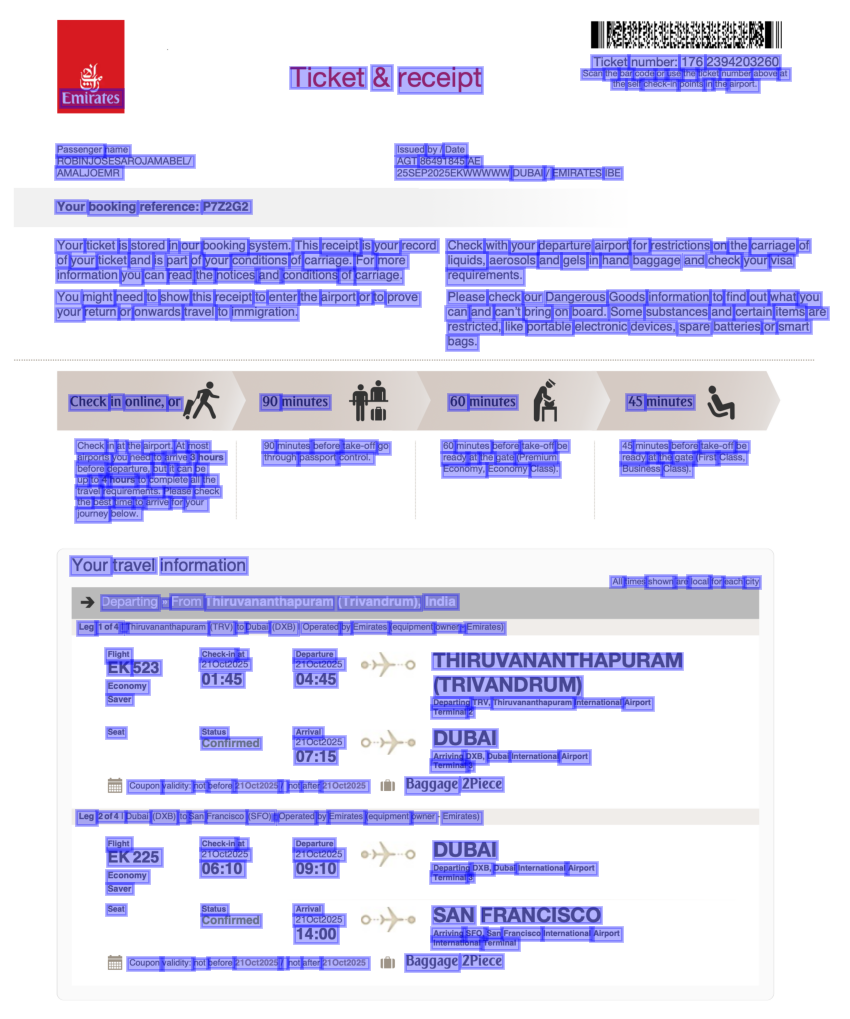

In [44]:
vis = visualize_page(out.pages[0].export(), out.pages[0].page, interactive=False, add_labels=False)


0: 1024x864 10 titles, 18 plain texts, 6 abandons, 7 figures, 2 figure_captions, 67.8ms
Speed: 5.5ms preprocess, 67.8ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 864)


(np.float64(-0.5), np.float64(1739.5), np.float64(2095.5), np.float64(-0.5))

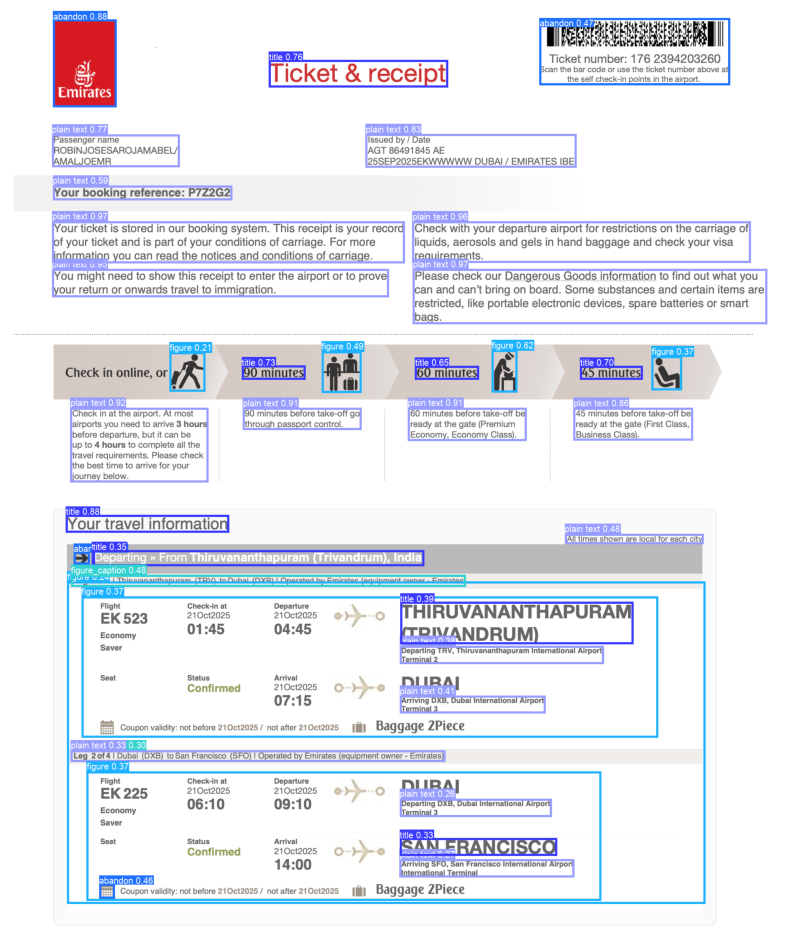

In [98]:
import cv2
from doclayout_yolo import YOLOv10

# Load the pre-trained model
model = YOLOv10("../models/yolo.pt")

# Perform prediction
det_res = model.predict(
    page,   # Image to predict
    imgsz=1024,        # Prediction image size
    conf=0.2,          # Confidence threshold
    device="mps"
)

# Annotate and save the result
annotated_frame = det_res[0].plot(pil=True, line_width=5, font_size=20)
plt.figure(figsize=(12, 12))
plt.imshow(annotated_frame)
plt.axis("off")

(np.float64(-0.5), np.float64(1739.5), np.float64(2095.5), np.float64(-0.5))

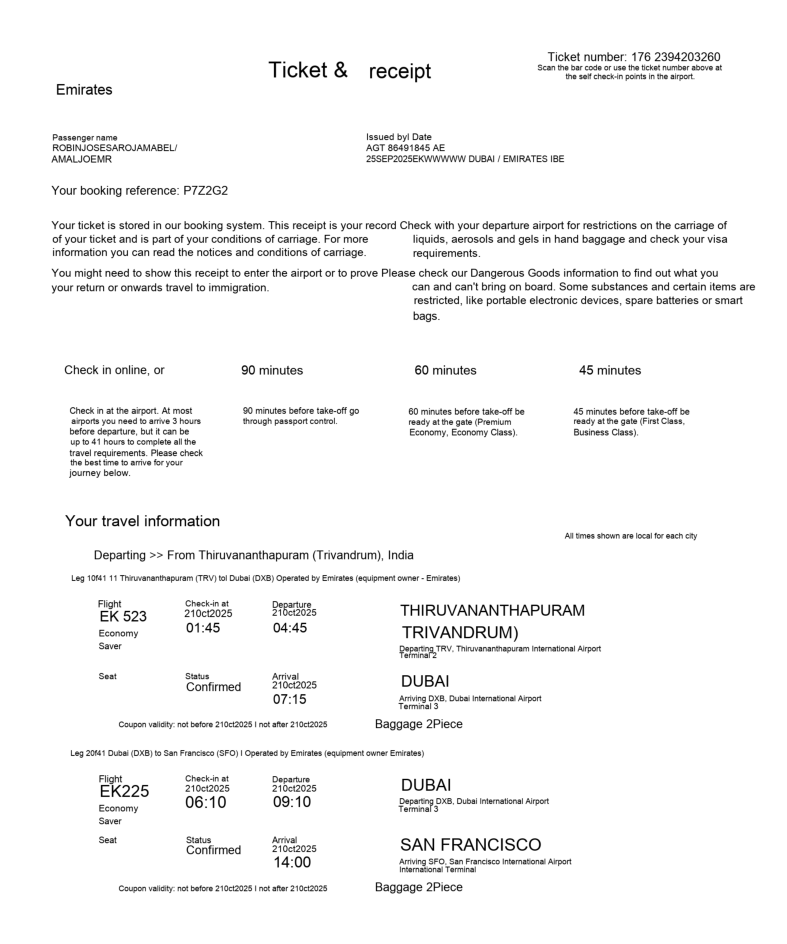

In [95]:
# for line in out.pages[0].blocks[0].lines:
#    for word in line.words:
#        print(word.value)

page_export['blocks'][0]['lines']

def combine_words_in_lines(page_export):
    page_export = page_export.copy()
    for block in page_export['blocks']:
        for line in block['lines']:
            combined_value = ' '.join([word['value'] for word in line['words']])
            line['words'] = [line['words'][0]]  # Keep only the first word's metadata
            line['words'][0]['value'] = combined_value  # Update the value to the
            line['words'][0]['geometry'] = line['geometry']  # Update geometry to line's geometry
            line['words'][0]['objectness_score'] = line['objectness_score']  # Set objectness score
    return page_export

combined_page_export = combine_words_in_lines(page_export)


from doctr.utils.reconstitution import synthesize_page
syn = synthesize_page(combined_page_export)
plt.figure(figsize=(12, 12))
plt.imshow(syn)
plt.axis('off')

In [103]:
page_export = page_export.copy()
values = []
for block in page_export['blocks']:
    for line in block['lines']:
        for word in line['words']:
            values.append(word['value'])
page_export

{'page_idx': 0,
 'dimensions': (2096, 1740),
 'orientation': {'value': None, 'confidence': None},
 'language': {'value': None, 'confidence': None},
 'blocks': [{'geometry': ((np.float64(0.054157686781609204),
     np.float64(0.0458984375)),
    (np.float64(0.9846623563218391), np.float64(0.9619140625))),
   'objectness_score': 0.7651482421066125,
   'lines': [{'geometry': ((np.float64(0.6999820402298851),
       np.float64(0.0458984375)),
      (np.float64(0.9270204741379311), np.float64(0.060546875))),
     'objectness_score': 0.7845475375652313,
     'words': [{'value': 'ടിക്കറ്റ് നമ്പര്: 176 2394203260',
       'confidence': 0.9789448976516724,
       'geometry': ((np.float64(0.6999820402298851), np.float64(0.0458984375)),
        (np.float64(0.9270204741379311), np.float64(0.060546875))),
       'objectness_score': 0.7845475375652313,
       'crop_orientation': {'value': 0, 'confidence': None}}]},
    {'geometry': ((np.float64(0.3364852729885057), np.float64(0.0556640625)),
      (

Device set to use mps:0


(np.float64(-0.5), np.float64(1739.5), np.float64(2095.5), np.float64(-0.5))

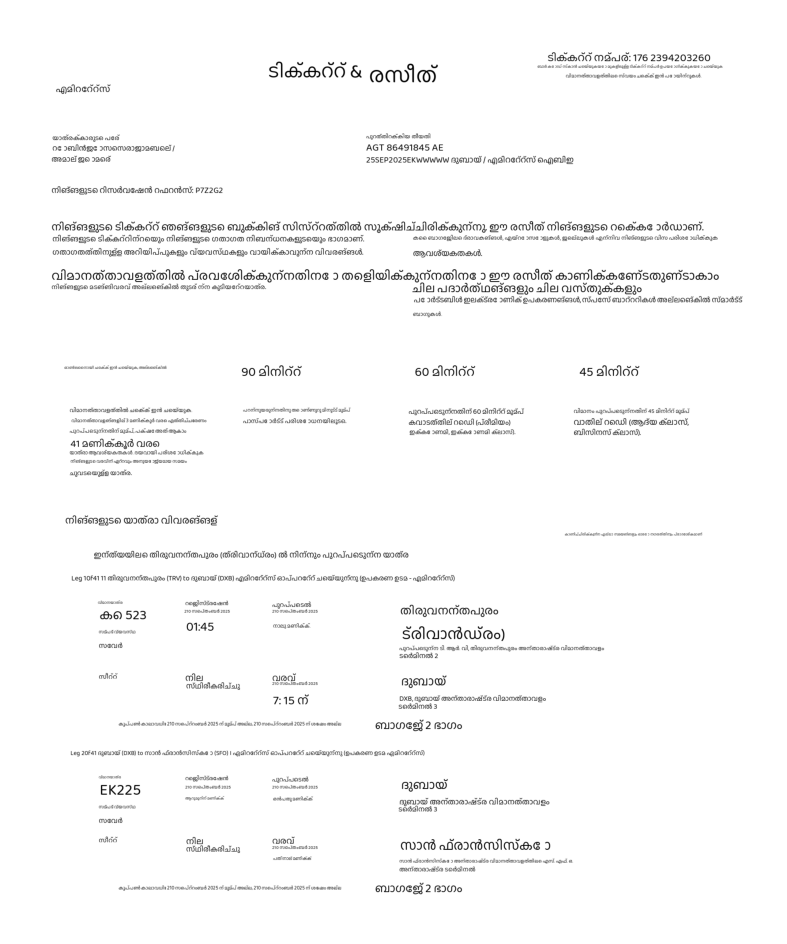

In [116]:
from transformers import pipeline


translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="eng_Latn", tgt_lang="mal_Mlym")
translator(["Hello, how are you?", "This is a test sentence."])


def translate(page_export):
    page_export = page_export.copy()
    values = []
    for block in page_export['blocks']:
        for line in block['lines']:
            for word in line['words']:
                values.append(word['value'])
    translations = translator(values)
    for i, block in enumerate(page_export['blocks']):
        for j, line in enumerate(block['lines']):
            for k, word in enumerate(line['words']):
                word['value'] = translations.pop(0)['translation_text']
    return page_export

# translated_page_export = translate(combined_page_export)
syn = synthesize_page(page_export, font_family='/System/Library/AssetsV2/com_apple_MobileAsset_Font7/5a224f093c7ff58ae98872248e5938769301bb72.asset/AssetData/BalooChettanMalayalam.ttc')
plt.figure(figsize=(12, 12))
plt.imshow(syn)
plt.axis('off')

In [112]:
import matplotlib.font_manager as fm
font_family = fm.findfont("Noto Sans")
font_family

'/Users/amaljoe/Desktop/Workspace/IITB/CS772/doctr/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [113]:
for f in fm.findSystemFonts(fontext='ttf'):
    if "malayalam" in f.lower():
        print(f)

/System/Library/Fonts/Supplemental/Malayalam MN.ttc
/System/Library/AssetsV2/com_apple_MobileAsset_Font7/25f6134c89b011288b72c7b81c9c22b2d6882471.asset/AssetData/SamaMalayalam.ttc
/System/Library/Fonts/Supplemental/Malayalam Sangam MN.ttc
/System/Library/AssetsV2/com_apple_MobileAsset_Font7/5a224f093c7ff58ae98872248e5938769301bb72.asset/AssetData/BalooChettanMalayalam.ttc


In [ ]:
from doctr.utils.visualization import visualize_page

# --- PLOT ALL 3 IN A SINGLE FIGURE ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1) Raw segmentation heatmap
axs[0].imshow(seg_map, cmap='inferno')
axs[0].set_title("Segmentation Heatmap")
axs[0].axis("off")

# 2) OCR result visualization
axs[1].imshow(ocr_vis)
axs[1].set_title("OCR Visualization")
axs[1].axis("off")

# 3) Synthesized page
axs[2].imshow(img)
axs[2].set_title("Reconstructed Page")
axs[2].axis("off")

plt.tight_layout()
plt.show()

array([[          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       ...,
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0]], shape=(2096, 1740), dtype=float32)